## Normal differential evolutionary algorithm (DE)

In [1]:
import matplotlib.pyplot as plt
import math
from statistics import median, stdev
from random import uniform, choice, randint, gauss
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import time

We employ **Holder table function** as the test function to check the perfomance of our DE

The Holder Table function has many local minima, with **four** global minima.

Global Minimum: $f(x^*)$ = **-19.2085**, at $x^*$ = **(8.05502, 9.66459), (8.05502, -9.66459), (-8.05502, 9.66459), (-8.05502, -9.66459)**

In [2]:
def Holder_table(X_min = -10, X_max = 10, Y_min = -10, Y_max = 10):
    '''This function is to generate the Holder Table function'''
    X, Y = get_X_AND_Y(X_min, X_max, Y_min, Y_max)
    Z = -np.abs(np.sin(X) * np.cos(Y) * np.exp(np.abs(1 - np.sqrt(X**2 + Y**2)/np.pi)))
    return X, Y, Z, 0, "Holder table function", -20

In [3]:
def Bukin(X_min = -15, X_max = -5, Y_min = -3, Y_max = 3):
    X, Y = get_X_AND_Y(X_min, X_max, Y_min, Y_max)
    Z = 100 * np.sqrt(np.abs(Y - 0.01 * X**2)) + 0.01 * np.abs(X + 10)
    return X, Y, Z, 200, "Bukin function", 0

We can visualise this test function as below

In [4]:
def draw_pic(X, Y, Z, z_max, title, z_min=0):
    '''This function is to visualise the 3-D plot'''
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.hot)
    ax.set_zlim(z_min, z_max)
    ax.set_title(title)
    plt.show()

def get_X_AND_Y(X_min, X_max, Y_min, Y_max):
    X = np.arange(X_min, X_max, 0.1)
    Y = np.arange(Y_min, Y_max, 0.1)
    X, Y = np.meshgrid(X, Y)
    return X, Y

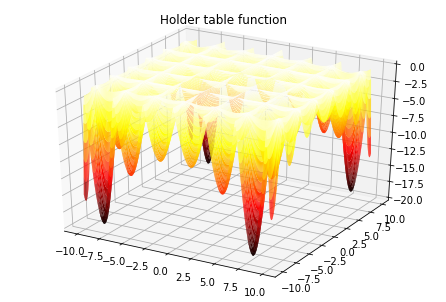

In [5]:
X, Y, Z, z_max, title, z_min = Holder_table()
draw_pic(X, Y, Z, z_max, title, z_min)

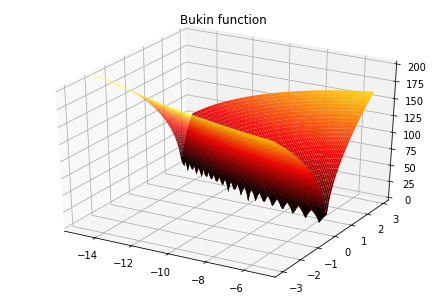

In [6]:
X, Y, Z, z_max, title, z_min = Bukin()
draw_pic(X, Y, Z, z_max, title, z_min)

In [7]:
def fit_fun(X):
    '''This is the fitness function'''
    # Use holden table function
    return -np.abs(np.sin(X[0]) * np.cos(X[1]) * np.exp(np.abs(1 - np.sqrt(X[0] ** 2 + X[1] ** 2) / np.pi)))

In [8]:
class Individual:
    '''This is the class for single individual'''
    
    def __init__(self, x_min, x_max, dim):
        self.__pos = np.array([x_min + random.random()*(x_max - x_min) for i in range(dim)])
        self.__mutation = np.array([0.0 for i in range(dim)])  # The individual after mutation
        self.__crossover = np.array([0.0 for i in range(dim)])  # The individual after crossover
        self.__fitnessValue = fit_fun(self.__pos)  # The fitness value for this individual

    def set_pos(self, i, value):
        self.__pos[i] = value

    def get_pos(self):
        return self.__pos

    def set_mutation(self, i, value):
        self.__mutation[i] = value

    def get_mutation(self):
        return self.__mutation

    def set_crossover(self, i, value):
        self.__crossover[i] = value

    def get_crossover(self):
        return self.__crossover

    def set_fitness_value(self, value):
        self.__fitnessValue = value

    def get_fitness_value(self):
        return self.__fitnessValue


In [9]:
class DE:
    def __init__(self, dim, size, iter_num, x_min, x_max, best_fitness_value=float('Inf'), F=0.5, CR=0.8):
        self.F = F     # Set F
        self.CR = CR   # Set CR
        self.dim = dim  # Set dimension
        self.size = size  # Set the size of the population
        self.iter_num = iter_num  # Set the number of iterations
        # Set the searching range
        self.x_min = x_min
        self.x_max = x_max
        
        self.best_fitness_value = best_fitness_value  # Set the best fitness score
        self.best_position = [0.0 for i in range(dim)]  # The best combination for the best fitness score
        self.fitness_val_list = []  # This list is to include the best fitness score in every single iter

        # Initialise the population
        self.individual_list = [Individual(self.x_min, self.x_max, self.dim) for i in range(self.size)]

    def get_kth_individual(self, k):
        return self.individual_list[k]

    def set_bestFitnessValue(self, value):
        self.best_fitness_value = value

    def get_bestFitnessValue(self):
        return self.best_fitness_value

    def set_bestPosition(self, i, value):
        self.best_position[i] = value

    def get_bestPosition(self):
        return self.best_position

    def mutation_fun(self):
        '''This function is for the mutation process
           Using "DE/rand/1" strategy
        '''
        for i in range(self.size):
            # Initialise three random indexes 
            r1 = r2 = r3 = 0
            # i, r1, r2, r3 should be mutually different
            while r1 == i or r2 == i or r3 == i or r2 == r1 or r3 == r1 or r3 == r2:
                # Randomly generate r1, r2, r3
                r1 = random.randint(0, self.size - 1)
                r2 = random.randint(0, self.size - 1)
                r3 = random.randint(0, self.size - 1)
            #     
            mutation = self.get_kth_individual(r1).get_pos() + \
                       self.F * (self.get_kth_individual(r2).get_pos() - self.get_kth_individual(r3).get_pos())
            for j in range(self.dim):
                # Check whether the mutated one exceeds the bounds or not
                if self.x_min <= mutation[j] <= self.x_max:
                    self.get_kth_individual(i).set_mutation(j, mutation[j])
                else:
                    rand_value = self.x_min + random.random()*(self.x_max - self.x_min)
                    self.get_kth_individual(i).set_mutation(j, rand_value)

    def crossover(self):
        '''This function is for the crossover process'''
        for unit in self.individual_list:
            for j in range(self.dim):
                rand_j = random.randint(0, self.dim - 1)
                rand_float = random.random()
                if rand_float <= self.CR or rand_j == j:
                    unit.set_crossover(j, unit.get_mutation()[j])
                else:
                    unit.set_crossover(j, unit.get_pos()[j])

    def selection(self):
        '''This function is for the selection process'''
        for individual in self.individual_list:
            new_fitness_value = fit_fun(individual.get_crossover())
            if new_fitness_value < individual.get_fitness_value():
                individual.set_fitness_value(new_fitness_value)
                for i in range(self.dim):
                    individual.set_pos(i, individual.get_crossover()[i])
            if new_fitness_value < self.get_bestFitnessValue():
                self.set_bestFitnessValue(new_fitness_value)
                for j in range(self.dim):
                    self.set_bestPosition(j, individual.get_crossover()[j])

    def fit(self):
        for i in range(self.iter_num):
            self.mutation_fun()
            self.crossover()
            self.selection()
            self.fitness_val_list.append(self.get_bestFitnessValue())
        return self.fitness_val_list, self.get_bestPosition()

The best combination (position):[8.083509018485788, -6.484657975387288]
The best result:-9.503572288762747


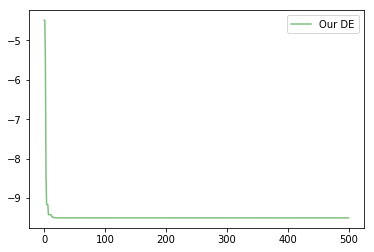

In [10]:
dim = 2
size = 6
iter_num = 500
bound = 10
max_vel = 0.05


de = DE(dim, size, iter_num, -bound, bound)
fit_var_list2, best_pos2 = de.fit()
print("The best combination (position):" + str(best_pos2))
print("The best result:" + str(fit_var_list2[-1]))
plt.plot(np.linspace(0, iter_num, iter_num), fit_var_list2, c="G", alpha=0.5, label="Our DE")

plt.legend()
plt.show()

## Contrast the performance when using different size

**Set the size of the population to a relatively small number: 5**

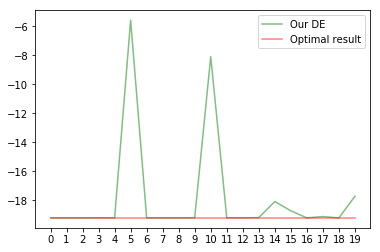

In [11]:
Optimal_result = -19.2085

dim = 2
size = 6
iter_num = 500
bound = 10
max_vel = 0.05

result_list = []

for i in range(20):
    de = DE(dim, size, iter_num, -bound, bound)
    fit_var_list2, best_pos2 = de.fit()
    result_list.append(fit_var_list2[-1])
plt.plot(result_list, c = 'G', alpha=0.5, label= 'Our DE')
plt.plot([Optimal_result for i in range(20)], c = 'R', alpha=0.5, label= 'Optimal result')
plt.xticks([i for i in range(20)])

plt.legend()
plt.show()

**Set the size of the population to a relatively large number: 30**

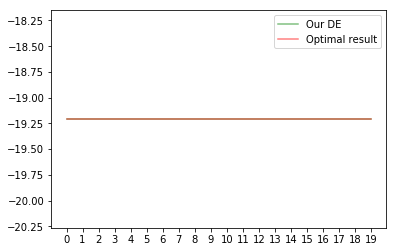

In [12]:
Optimal_result = -19.2085

dim = 2
size = 30
iter_num = 500
bound = 10
max_vel = 0.05

result_list = []

for i in range(20):
    de = DE(dim, size, iter_num, -bound, bound)
    fit_var_list2, best_pos2 = de.fit()
    result_list.append(round(fit_var_list2[-1], 4))
plt.plot(result_list, c = 'G', alpha=0.5, label= 'Our DE')
plt.plot([Optimal_result for i in range(20)], c = 'R', alpha=0.5, label= 'Optimal result')
plt.xticks([i for i in range(20)])

plt.legend()
plt.show()

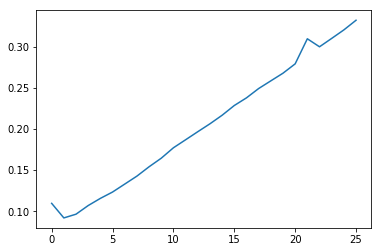

In [15]:
size_list = [i for i in range(5, 31)]
time_list = []

for i in size_list:
    
    time_start=time.time()
    de = DE(dim, i, iter_num, -bound, bound)
    fit_var_list2, best_pos2 = de.fit()   
    time_end=time.time()
    time_used = time_end - time_start
    
    time_list.append(time_used)
    
plt.plot(time_list[:26])
plt.show()